In [4]:
from Test_lib import *

range_r, x_koord, y_koord, z_koord = 5,0,0,0
factor = 50

dict_10_50 = generate_dict(range_r,factor)


In [5]:
number_of_winkel = 1000
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

In [6]:
start = time.process_time()
result = kegel_from_dict(dict_10_50, factor, x_koord, y_koord, z_koord, alpha, beta, False)
print("Zeit Cache, 1000 verschiedene Winkel",time.process_time() - start)

Zeit Cache, 1000 verschiedene Winkel 0.0


In [7]:
# Vorübergehende Version, kann deutlich beschleunigt werden, siehe rotation_kegel
def reverse_rotate_and_translate_data(data, alpha,  beta, x_delta=0, y_delta=0, z_delta=0):
    # Drehung um -alpha und -beta um die Originale Position zu bestimmen
    sin_alpha = np.sin(-alpha)
    sin_beta = np.sin(-beta)
    cos_alpha = np.cos(-alpha)
    cos_beta = np.cos(-beta)

    x,y,z = data
    # Translation in den Ursprung des Koordinatensystems für die Rotation
    x -= x_delta
    y -= y_delta
    z -= z_delta
    # erst rotation um -alpha um die x achse, dann rotation um -beta um die y achse
    x_rot = z*cos_alpha*sin_beta + x*cos_beta + y*sin_alpha*sin_beta
    y_rot = y*cos_alpha - z*sin_alpha
    z_rot = y*sin_alpha*cos_beta - x*sin_beta + z*cos_alpha*cos_beta

    return(x_rot, y_rot, z_rot)

Anpassung der schnellen ungenauen berechnung der Kegel.<br> 
Da die Funktion zur bewertung der Punlte kontinuiertlich ist, sollte dies kein Problem sein.

In [8]:
# anpassung der schnellen ungenauen berechnung der Kegel, da die Funktion zur bewertung der Punlte kontinuiertlich ist.
def reverse_rotate_and_translate_data(data, x_koord = 0, y_koord = 0, z_koord = 0, alpha = np.array([]), beta = np.array([])):
    # Rotation zuerst um die y-Achse winkel Beta und anschließend um die x-Achse winkel Alpha
    # x_mask_3d = data[:,0,:] - x_koord
    # y_mask_3d = data[:,1,:] - y_koord
    # z_mask_3d = data[:,2,:] - z_koord

    data[:,0,:] -= x_koord
    data[:,1,:] -= y_koord
    data[:,2,:] -= z_koord
    # Filtere Punkte innerhalb des Kegels
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    # Erzeuge 3D-Arrays für x, y und z Koordinaten
    rotation_matrix = np.empty((len(alpha), 3, 3))

    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.ravel()
    rotation_matrix[:, 0, 1] = (sin_alpha*sin_beta).ravel()
    rotation_matrix[:, 0, 2] = (cos_alpha*sin_beta).ravel()

    rotation_matrix[:, 1, 0] = np.zeros_like(cos_beta).ravel()
    rotation_matrix[:, 1, 1] = cos_alpha.ravel()
    rotation_matrix[:, 1, 2] = -sin_alpha.ravel()

    rotation_matrix[:, 2, 0] = -sin_beta.ravel()
    rotation_matrix[:, 2, 1] = (sin_alpha*cos_beta).ravel()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).ravel()
    
    # Dimension der x,y,z anheben
    # x_mask_3d = np.tile(x_mask.flatten(), (len(alpha.T), 1))
    # y_mask_3d = np.tile(y_mask.flatten(), (len(alpha.T), 1))
    # z_mask_3d = np.tile(z_mask.flatten(), (len(alpha.T), 1))

    # Wende die Rotationsmatrix auf die x- und y-Koordinaten an
    # rotation_matrix = np.transpose(rotation_matrix, axes=(0, 2, 1))
    print(rotation_matrix.shape, data.shape)
    # Multipliziere die Rotationsmatrizen mit den Daten
    # result = np.matmul(rotation_matrix, data)


    result = np.matmul(rotation_matrix, data)

    return result

In [9]:
result.shape

(1000, 3, 167)

In [10]:
#Im Beispiel von einem Winkel i wird hier die Gewichtung durch Gauss gezeigt
i = 0
# Um die Punkte mit der Gaussfunktion bewerten zu können werden die Punkte im Kegel zurück in den Ursprung 
# versetzt und in die ursprünglioche position zurück gedreht
reversed_result = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)


(1000, 3, 3) (1000, 3, 167)


In [10]:
plot_data(*get_Duplicates_new(reversed_result), 40,40,40)

KeyboardInterrupt: 

In [74]:
plot_data(*get_Duplicates_new(reversed_result), 40,40,40)

KeyboardInterrupt: 

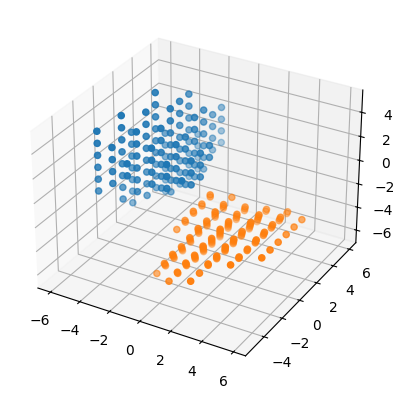

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*result[2])
ax.scatter(*reversed_result[2])

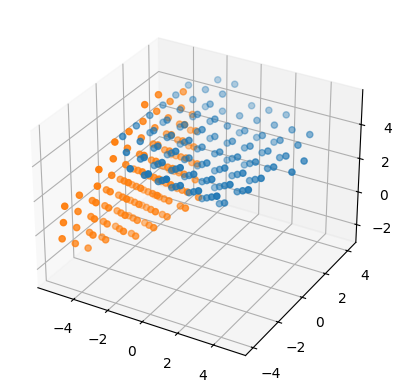

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*result[3])
ax.scatter(*reversed_result[3])

In [13]:
def rotation_kegel(range_r = 10, x_koord = 0, y_koord = 0, z_koord = 0, alpha = np.array([]), beta = np.array([]), no_dup=False):
    # Rotation zuerst um die y-Achse winkel Beta und anschließend um die x-Achse winkel Alpha
    x = np.linspace(-range_r*2, range_r*2, range_r*4+1)
    y = np.copy(x)
    z = np.copy(x)

    # Erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)

    # Mask für innerhalb des Zylinders
    mask = ((z_grid**2 + y_grid**2) < x_grid**2) & (0 < x_grid) & (range_r > x_grid)
    # Filtere Punkte innerhalb des Kegels
    x_mask = x_grid[mask]
    y_mask = y_grid[mask]
    z_mask = z_grid[mask]
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    # Erzeuge 3D-Arrays für x, y und z Koordinaten
    rotation_matrix = np.empty((len(alpha), 3, 3))

    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.flatten()
    rotation_matrix[:, 0, 1] = np.zeros_like(cos_beta).flatten()
    rotation_matrix[:, 0, 2] = sin_beta.flatten()

    rotation_matrix[:, 1, 0] = (sin_alpha*sin_beta).flatten()
    rotation_matrix[:, 1, 1] = cos_alpha.flatten()
    rotation_matrix[:, 1, 2] = (-sin_alpha*cos_beta).flatten()

    rotation_matrix[:, 2, 0] = (-cos_alpha*sin_beta).flatten()
    rotation_matrix[:, 2, 1] = sin_alpha.flatten()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).flatten()
    

    # Dimension der x,y,z anheben
    x_mask_3d = np.tile(x_mask.flatten(), (len(alpha.T), 1))
    y_mask_3d = np.tile(y_mask.flatten(), (len(alpha.T), 1))
    z_mask_3d = np.tile(z_mask.flatten(), (len(alpha.T), 1))
    
    print(rotation_matrix.shape, np.vstack([x_mask_3d, y_mask_3d, z_mask_3d]).shape, y_mask_3d.shape, x_mask.shape)
    # Wende die Rotationsmatrix auf die x- und y-Koordinaten an
    result = np.dot(rotation_matrix, np.vstack([x_mask_3d, y_mask_3d, z_mask_3d]))
    # x = result[i,0,:]
    # y = result[i,1,:]
    # z = result[i,2,:]

    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord

    # Falls gewollt werden hier die doppelten Punkte die durch das Runden auftreten herausgefilert und mit den Koordinaten 0,0,0 erstetzt
    if no_dup:
        result = np.round(result)
        no_duplicates_with_zero = np.empty(np.shape(result))
        for i in range(np.shape(result)[0]):
            no_duplicates_with_zero[i,:,:] = np.hstack((np.unique(result[i,:,:], axis=1), np.zeros((3, np.shape(result[i,:,:])[1]-np.shape(np.unique(result[i,:,:], axis=1))[1]))))

        return no_duplicates_with_zero
    else:
        return result

In [14]:
res = rotation_kegel(range_r, x_koord, y_koord, z_koord, alpha, beta)
rev_res = reverse_rotate_and_translate_data(res, x_koord, y_koord, z_koord, alpha, beta)

(1000, 3, 3) (3, 80) (1, 80) (80,)
(1000, 3, 3) (1000, 3, 80)


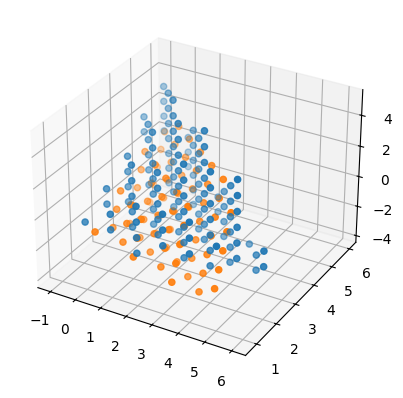

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*result[1])
ax.scatter(*res[1])

In [16]:
i =  0

In [17]:
cos_alpha = np.cos(alpha)
sin_alpha = np.sin(alpha)
cos_beta = np.cos(beta)
sin_beta = np.sin(beta)
# Karthesische Koordinate der symetrieachse berehnen
x = (cos_beta)
y = (sin_alpha*sin_beta)
z = (-cos_alpha*sin_beta)
i += 1
x[i],y[i],z[i]

(array([5.36e-01]), array([8.28e-01]), array([-1.66e-01]))

+   +   +	2
+   +   -	3
+   -   +	2
+   -   -	1
-   +   +	2
-   +   -	3
-   -   +	2
-   -   -   1

In [ ]:
-   -   -   1
+   -   -	1
+   +   +	2
+   -   +	2
-   +   +	2
-   -   +	2
+   +   -	3
-   +   -	3

In [ ]:
mask_1 = (y<0) & (z<0) & (x!=0)
mask_2 = (z>=0) & (x!=0)
mask_3 = (y>=0) & (z<0)


In [26]:
alpha2 = np.array([math.pi*0.8])
beta2 = np.array([math.pi/2])
cos_alpha = np.cos(alpha2)
sin_alpha = np.sin(alpha2)
cos_beta = np.cos(beta2)
sin_beta = np.sin(beta2)
# Karthesische Koordinate der symetrieachse berehnen
x = (cos_beta)
y = (sin_alpha*sin_beta)
z = (-cos_alpha*sin_beta)
i += 0
x[i],y[i],z[i]


IndexError: index 1 is out of bounds for axis 0 with size 1

was ist bei == 0?<br>
x == 0, 3<br>
y == 0, 3<br>
z == 0, 2<br>
(z == 0) & (y == 0), egal<br>

In [18]:
# 1
(2*math.pi + np.arcsin(y[i]/np.sin(np.arccos(x[i]))))*180/math.pi


array([4.39e+02])

In [19]:
# 2
(math.pi-np.arcsin(y[i]/np.sin(np.arccos(x[i]))))*180/math.pi


array([1.01e+02])

In [20]:
# 3
np.arccos(-z[i]/np.sin(np.arccos(x[i])))*180/math.pi


array([7.87e+01])

In [21]:
np.arcsin(y[i]/range_r)*180/math.pi


array([9.53e+00])

In [25]:
alpha1 = np.arctan2(z[i],y[i])+math.pi/2
beta1 = np.arccos(x[i]) # Richtig für x>0, y<0, z<0,für x<0 , y>0, z>0 .... Also immer richtig
alpha1*180/math.pi, beta1*180/math.pi

(array([7.87e+01]), array([5.76e+01]))

In [23]:
alpha[i]*180/math.pi, beta[i]*180/math.pi

(array([7.87e+01]), array([5.76e+01]))

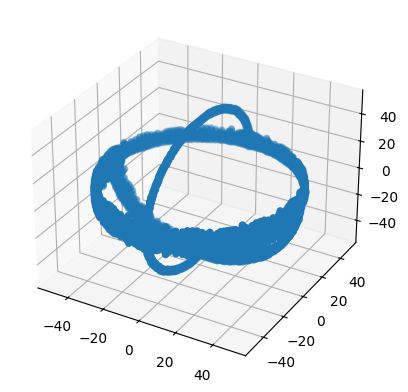

In [ ]:


test = get_point1(factor)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*test.T)
# z==0, x==0 & (y>0 & z<0), y==0 & z<0

Es gibt probleme in den masken

In [ ]:
    mask_1 = (Kugelschale[:,1]<0) & (Kugelschale[:,2]<0) & (Kugelschale[:,0]!=0)
    mask_2 = (Kugelschale[:,2]>=0) & (Kugelschale[:,0]!=0)
    mask_3 = (Kugelschale[:,1]>=0) & (Kugelschale[:,2]<0)

In [ ]:
    mask_1 = (Kugelschale[:,1]<0) & (Kugelschale[:,2]<0) & (Kugelschale[:,0]!=0)
    mask_2 = (Kugelschale[:,2]>0) & (Kugelschale[:,0]!=0)
    mask_3 = (Kugelschale[:,1]>0) & (Kugelschale[:,2]<0)

4058


d:\dokumente\Python Skripts\Bachelor\BachelorArbeit\Test_lib.py:1013: RuntimeWarning: invalid value encountered in arcsin
  alpha[mask_1] = 2*math.pi + np.arcsin(Kugelschale[mask_1,1]/range_r/np.sin(np.arccos(Kugelschale[mask_1,0]/range_r)))
d:\dokumente\Python Skripts\Bachelor\BachelorArbeit\Test_lib.py:1014: RuntimeWarning: invalid value encountered in arcsin
  alpha[mask_2] = math.pi-np.arcsin(Kugelschale[mask_2,1]/range_r/np.sin(np.arccos(Kugelschale[mask_2,0]/range_r)))
d:\dokumente\Python Skripts\Bachelor\BachelorArbeit\Test_lib.py:1015: RuntimeWarning: invalid value encountered in arccos
  alpha[mask_3] = np.arccos(-Kugelschale[mask_3,2]/range_r/np.sin(np.arccos(Kugelschale[mask_3,0]/range_r)))


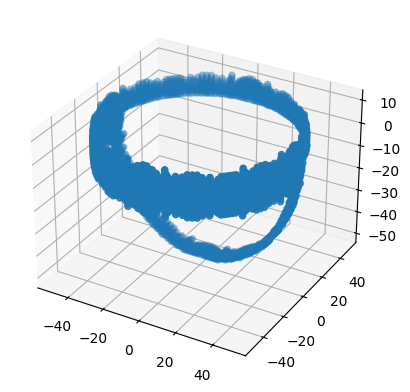

In [1]:
from Test_lib import *

range_r, x_koord, y_koord, z_koord = 5,0,0,0
factor = 50

test = get_point1(factor)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*test.T)
# z==0, x==0 & (y>0 & z<0), y==0 & z<0

In [166]:
# color_factor ist später das Gewicht der ODFs
color_factor = gauss_2d(yf,zf)

# Bild wird ausgegeben
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
# Farbverlauf ist von Rot(kleines Gewicht) bis Blau(großes Gewicht)
red = Color("red")
colors = list(red.range_to(Color("blue"), int(1000*np.max(color_factor)+1)))
for xs,ys,zs,col in zip(x,y,z,color_factor):
    ax.scatter(xs,ys,zs, c = str(colors[int(1000*col)]))
plt.show()

NameError: name 'yf' is not defined

In [14]:
from Test_lib import *

range_r, x_koord, y_koord, z_koord = 5,0,0,0
factor = 50

number_of_winkel = 1000
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

i=0

In [16]:
cos_alpha = np.cos(alpha)
sin_alpha = np.sin(alpha)
cos_beta = np.cos(beta)
sin_beta = np.sin(beta)
# Karthesische Koordinate der symetrieachse berehnen
x = (cos_beta)
y = (sin_alpha*sin_beta)
z = (-cos_alpha*sin_beta)
koords = np.concatenate((x,y,z), axis=1)
koords_rounded_int = np.array(np.round(koords*factor, 0), dtype=int)
x,y,z = koords_rounded_int.T/factor
i += 1
x[i],y[i],z[i]

(0.02, 0.88, -0.46)

In [17]:
# 1
alpha1 = np.arctan2(z[i],y[i])+math.pi/2
beta1 = np.arccos(x[i]) # Richtig für x>0, y<0, z<0,für x<0 , y>0, z>0 .... Also immer richtig
alpha1*180/math.pi, beta1*180/math.pi

(62.40270413135628, 88.8540080016114)

# Hat koords_in_kegel_cache einen Fehler?

In [18]:
alpha[i]*180/math.pi, beta[i]*180/math.pi

(array([6.23e+01]), array([8.90e+01]))

+   +   +	1
+   +   -	1
+   -   +	1
+   -   -	1
-   +   +	1
-   +   -	1
-   -   +	1
-   -   -   1

In [4]:
from Test_lib import *

range_r, x_koord, y_koord, z_koord = 5,0,0,0
factor = 200

dict_10_50 = generate_dict(range_r,factor)

0


In [5]:
number_of_winkel = 1000
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2
result = kegel_from_dict(dict_10_50, factor, x_koord, y_koord, z_koord, alpha, beta, False)

In [6]:
result = kegel_from_dict(dict_10_50, factor, x_koord, y_koord, z_koord, alpha, beta, False)

In [61]:
# anpassung der schnellen ungenauen berechnung der Kegel, da die Funktion zur bewertung der Punlte kontinuiertlich ist.
def reverse_rotate_and_translate_data(data, x_koord = 0, y_koord = 0, z_koord = 0, alpha = np.array([]), beta = np.array([])):
    # Rotation zuerst um die y-Achse winkel Beta und anschließend um die x-Achse winkel Alpha
    # x_mask_3d = data[:,0,:] - x_koord
    # y_mask_3d = data[:,1,:] - y_koord
    # z_mask_3d = data[:,2,:] - z_koord

    data[:,0,:] -= x_koord
    data[:,1,:] -= y_koord
    data[:,2,:] -= z_koord
    # Filtere Punkte innerhalb des Kegels
    cos_alpha = np.cos(-alpha)
    sin_alpha = np.sin(-alpha)
    cos_beta = np.cos(-beta)
    sin_beta = np.sin(-beta)
    # Erzeuge 3D-Arrays für x, y und z Koordinaten
    rotation_matrix = np.empty((len(alpha), 3, 3))

    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.ravel()
    rotation_matrix[:, 0, 1] = (sin_alpha*sin_beta).ravel()
    rotation_matrix[:, 0, 2] = (cos_alpha*sin_beta).ravel()

    rotation_matrix[:, 1, 0] = np.zeros_like(cos_beta).ravel()
    rotation_matrix[:, 1, 1] = cos_alpha.ravel()
    rotation_matrix[:, 1, 2] = -sin_alpha.ravel()

    rotation_matrix[:, 2, 0] = -sin_beta.ravel()
    rotation_matrix[:, 2, 1] = (sin_alpha*cos_beta).ravel()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).ravel()
    
    # Dimension der x,y,z anheben
    # x_mask_3d = np.tile(x_mask.flatten(), (len(alpha.T), 1))
    # y_mask_3d = np.tile(y_mask.flatten(), (len(alpha.T), 1))
    # z_mask_3d = np.tile(z_mask.flatten(), (len(alpha.T), 1))

    # Wende die Rotationsmatrix auf die x- und y-Koordinaten an
    # rotation_matrix = np.transpose(rotation_matrix, axes=(0, 2, 1))
    print(rotation_matrix.shape, data.shape)
    # Multipliziere die Rotationsmatrizen mit den Daten
    # result = np.matmul(rotation_matrix, data)


    result = np.matmul(rotation_matrix, data)

    return result

In [7]:
reversed_result = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)

(1000, 3, 3) (1000, 3, 167)


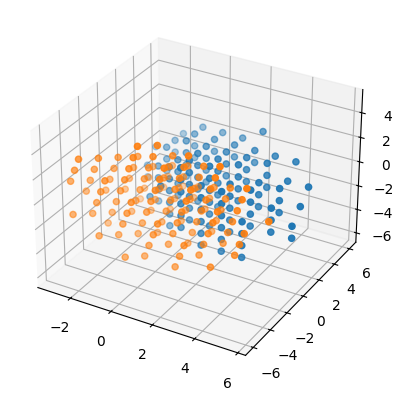

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*result[6])
ax.scatter(*reversed_result[6])

In [9]:
def rotation_kegel(range_r = 10, x_koord = 0, y_koord = 0, z_koord = 0, alpha = np.array([]), beta = np.array([]), no_dup=False):
    # Rotation zuerst um die y-Achse winkel Beta und anschließend um die x-Achse winkel Alpha
    x = np.linspace(-range_r*2, range_r*2, range_r*4+1)
    y = np.copy(x)
    z = np.copy(x)

    # Erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)

    # Mask für innerhalb des Zylinders
    mask = ((z_grid**2 + y_grid**2) < x_grid**2) & (0 < x_grid) & (range_r > x_grid)
    # Filtere Punkte innerhalb des Kegels
    x_mask = x_grid[mask]
    y_mask = y_grid[mask]
    z_mask = z_grid[mask]
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    # Erzeuge 3D-Arrays für x, y und z Koordinaten
    rotation_matrix = np.empty((len(alpha), 3, 3))

    # Fülle die Rotationsmatrizen für alle Winkel gleichzeitig
    rotation_matrix[:, 0, 0] = cos_beta.flatten()
    rotation_matrix[:, 0, 1] = np.zeros_like(cos_beta).flatten()
    rotation_matrix[:, 0, 2] = sin_beta.flatten()

    rotation_matrix[:, 1, 0] = (sin_alpha*sin_beta).flatten()
    rotation_matrix[:, 1, 1] = cos_alpha.flatten()
    rotation_matrix[:, 1, 2] = (-sin_alpha*cos_beta).flatten()

    rotation_matrix[:, 2, 0] = (-cos_alpha*sin_beta).flatten()
    rotation_matrix[:, 2, 1] = sin_alpha.flatten()
    rotation_matrix[:, 2, 2] = (cos_alpha*cos_beta).flatten()
    

    # Dimension der x,y,z anheben
    x_mask_3d = np.tile(x_mask.flatten(), (len(alpha.T), 1))
    y_mask_3d = np.tile(y_mask.flatten(), (len(alpha.T), 1))
    z_mask_3d = np.tile(z_mask.flatten(), (len(alpha.T), 1))
    
    print(rotation_matrix.shape, np.vstack([x_mask_3d, y_mask_3d, z_mask_3d]).shape, y_mask_3d.shape, x_mask.shape)
    # Wende die Rotationsmatrix auf die x- und y-Koordinaten an
    result = np.dot(rotation_matrix, np.vstack([x_mask_3d, y_mask_3d, z_mask_3d]))
    # x = result[i,0,:]
    # y = result[i,1,:]
    # z = result[i,2,:]

    result[:,0,:] += x_koord
    result[:,1,:] += y_koord
    result[:,2,:] += z_koord

    # Falls gewollt werden hier die doppelten Punkte die durch das Runden auftreten herausgefilert und mit den Koordinaten 0,0,0 erstetzt
    if no_dup:
        result = np.round(result)
        no_duplicates_with_zero = np.empty(np.shape(result))
        for i in range(np.shape(result)[0]):
            no_duplicates_with_zero[i,:,:] = np.hstack((np.unique(result[i,:,:], axis=1), np.zeros((3, np.shape(result[i,:,:])[1]-np.shape(np.unique(result[i,:,:], axis=1))[1]))))

        return no_duplicates_with_zero
    else:
        return result

In [10]:
res = rotation_kegel(range_r, x_koord, y_koord, z_koord, alpha, beta)

(1000, 3, 3) (3, 80) (1, 80) (80,)


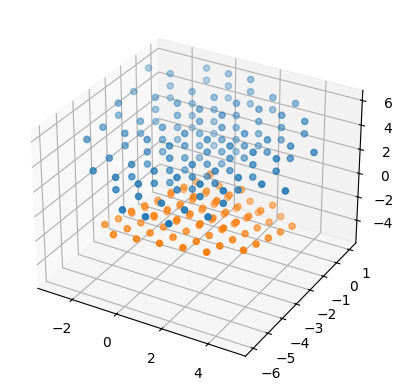

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*result[3])
ax.scatter(*res[3])

# Ist koords_in_kegel_cache falsch?

In [1]:
from Test_lib import *

range_r, x_koord, y_koord, z_koord = 5,0,0,0
factor = 200


In [2]:
number_of_winkel = 100
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

In [3]:
result = koords_in_kegel_cache(range_r, alpha, beta)
res = rotation_kegel(range_r, x_koord, y_koord, z_koord, alpha, beta)
i=0

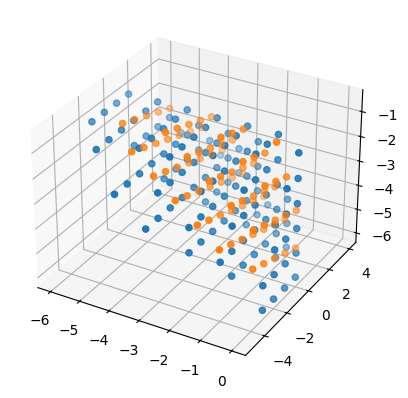

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*result[i])
# ax.scatter(*resul[i])
ax.scatter(*res[i])
# ax.scatter(*re[i])
i += 1

In [5]:
reverse_result = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, beta, alpha)


(100, 3, 3) (100, 3, 167)


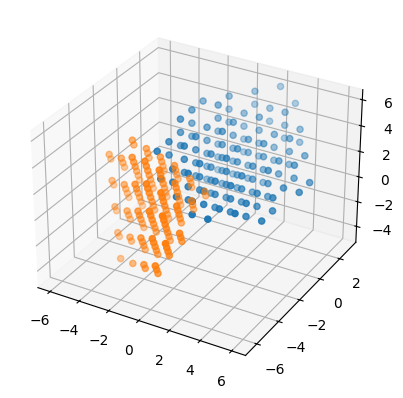

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*result[i])
ax.scatter(*reverse_result[i])
i += 1

koords_in_kegel_cache scheint das problem zu sein

In [ ]:
def koords_in_kegel_cache(range_r = 4, alpha = np.array([]), beta = np.array([])):
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    cos_alpha_cos_beta = cos_alpha*cos_beta
    sin_alpha_cos_beta = sin_alpha*cos_beta
    cos_alpha_sin_beta = cos_alpha*sin_beta
    sin_alpha_sin_beta = sin_alpha*sin_beta

    x = np.linspace(-range_r*2, range_r*2, range_r*4+1)
    y = np.copy(x)
    z = np.copy(x)
    length = int(((2*range_r)**3)/6)+1

    # Erstelle das Gitter für x, y und z
    x_grid, y_grid, z_grid = np.meshgrid(x, y, z)
    # test_x = np.copy(x_grid)
    result = np.empty((len(cos_alpha), 3, length)) * np.nan

    for i, ca, sa, cb, sb, cacb, sacb, casb, sasb in zip(range(len(cos_alpha)), cos_alpha, sin_alpha, cos_beta, sin_beta, cos_alpha_cos_beta, sin_alpha_cos_beta, cos_alpha_sin_beta, sin_alpha_sin_beta):
        # erst x achse dann y achse
        mask = (((ca*y_grid-sa*z_grid)**2 + (cacb*z_grid-sb*x_grid+sacb*y_grid)**2 < (casb*z_grid+sasb*y_grid+cb*x_grid)**2) & (0 < (casb*z_grid+sasb*y_grid+cb*x_grid)) & (range_r > (casb*z_grid+sasb*y_grid+cb*x_grid)))
        # x,y,z werte mit der spezifischen Maske auf die Kegel zuschneiden
        x_mask = x_grid[mask]
        y_mask = y_grid[mask]
        z_mask = z_grid[mask]
        data = np.array([x_mask, y_mask, z_mask])
        result[i,:,:np.shape(data)[1]] = data
    return result

In [98]:
try1 = np.sin(-alpha)
try2 = np.sin(math.pi*2-alpha)
trydiff = np.abs(try1-try2)

In [99]:
np.average(trydiff)

1.5591694602079541e-16

In [17]:
def gauss_2d(y, z, mu_y=0,mu_z=0,sigma=2):
    return 1/(np.sqrt(math.pi*2)*sigma)*np.exp(-1/2*(((y-mu_y)/sigma)**2+((z-mu_z)/sigma)**2))

In [123]:
number_of_winkel = 100
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

result = koords_in_kegel_cache(range_r, alpha, beta)

ValueError: cannot convert float NaN to integer

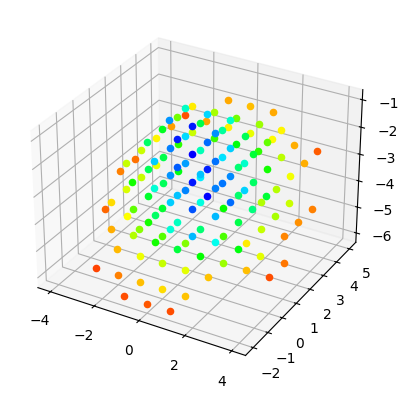

In [126]:
i = 3
# Doppelte Punkte können durch das Runden auftreten, diese werden hier herausgenommen
x,y,z  = result[i,:,:]
# Um die Punkte mit der Gaussfunktion bewerten zu können werden die Punkte im Kegel zurück in den Ursprung 
# versetzt und in die ursprünglioche position zurück gedreht
# xf,yf,zf = reverse_rotate_and_translate_data((x,y,z), alpha[i], beta[i], 0,0,0)
# color_factor ist später das Gewicht der ODFs
color_factor = gauss_2d_roated(x,y,z, alpha, beta)

# Bild wird ausgegeben
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
# Farbverlauf ist von Rot(kleines Gewicht) bis Blau(großes Gewicht)
red = Color("red")
colors = list(red.range_to(Color("blue"), int(1000*np.nanmax(color_factor[i])+1)))
for xs,ys,zs,col in zip(x,y,z,color_factor[i]):
    ax.scatter(xs,ys,zs, c = str(colors[int(1000*col)]))
plt.show()

In [117]:
np.nanmax(color_factor[0])

0.17642472362675166

# Das Vorzeichen war natürlich falsch!!!! <br>

Die Rotation der Koordinaten hat natürlich die negativen Winkel....

In [ ]:
from Test_lib import *

range_r, x_koord, y_koord, z_koord = 5,0,0,0
factor = 100
dict_5_100 = generate_dict(5,100) 

0


In [ ]:
number_of_winkel = 1000
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

result = kegel_from_dict(dict_5_100, factor, x_koord, y_koord, z_koord, alpha, beta)
res = rotation_kegel(range_r, x_koord, y_koord, z_koord, alpha, beta)
result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)

(1000, 3, 3) (1000, 3, 167)


In [ ]:
i = 0

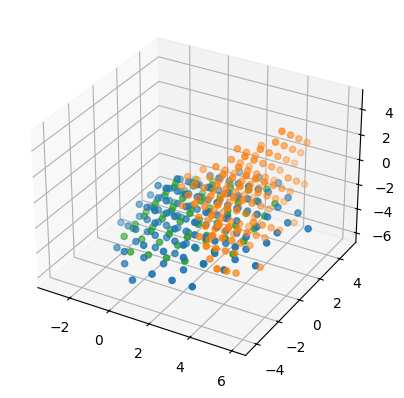

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(*result[i])
ax.scatter(*result_rot[i])
ax.scatter(*res[i])
# ax.scatter(*re[i])
i += 1

### Für factor = 100 trifft der Kegel sehr gut die Richtung

In [18]:
i = 3
# Doppelte Punkte können durch das Runden auftreten, diese werden hier herausgenommen
x,y,z  = result[i,:,:]
# Um die Punkte mit der Gaussfunktion bewerten zu können werden die Punkte im Kegel zurück in den Ursprung 
# versetzt und in die ursprünglioche position zurück gedreht
xf,yf,zf = reverse_rotate_and_translate_data((x,y,z), alpha[i], beta[i], 0,0,0)
# color_factor ist später das Gewicht der ODFs
color_factor = gauss_2d(y,z,y_koord,z_koord)

# Bild wird ausgegeben
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
# Farbverlauf ist von Rot(kleines Gewicht) bis Blau(großes Gewicht)
red = Color("red")
colors = list(red.range_to(Color("blue"), int(1000*np.nanmax(color_factor[i])+1)))
for xs,ys,zs,col in zip(x,y,z,color_factor[i]):
    ax.scatter(xs,ys,zs, c = str(colors[int(1000*col)]))
plt.show()

TypeError: tuple indices must be integers or slices, not tuple

In [1]:
from Test_lib import *

range_r, x_koord, y_koord, z_koord = 5,0,0,0
factor = 100
dict_5_100 = generate_dict(range_r, factor) 

0


In [2]:
number_of_winkel = 1000
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

result = kegel_from_dict(dict_5_100, factor, x_koord, y_koord, z_koord, alpha, beta)
result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)

weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord)

In [7]:
i=0
weights.shape

(1000, 167)

ValueError: cannot convert float NaN to integer

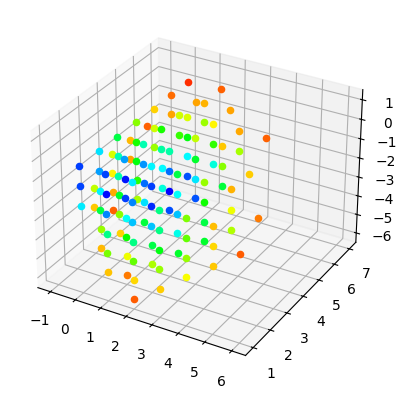

In [5]:
color_factor = weights

# Bild wird ausgegeben
fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
# Farbverlauf ist von Rot(kleines Gewicht) bis Blau(großes Gewicht)
red = Color("red")
colors = list(red.range_to(Color("blue"), int(1000*np.nanmax(color_factor[i])+1)))
for xs,ys,zs,col in zip(*result[i],color_factor[i]):
    ax.scatter(xs,ys,zs, c = str(colors[int(1000*col)]))
plt.show()

In [8]:
weights

array([[1.54e-01, 1.86e-01, 1.87e-01, ..., nan, nan, nan],
       [2.60e-02, 2.50e-02, 2.15e-02, ..., nan, nan, nan],
       [1.77e-02, 2.37e-02, 5.41e-02, ..., nan, nan, nan],
       ...,
       [1.78e-02, 2.23e-02, 2.18e-02, ..., nan, nan, nan],
       [1.84e-01, 1.96e-01, 1.78e-01, ..., nan, nan, nan],
       [9.66e-03, 1.21e-02, 1.60e-02, ..., nan, nan, nan]])

# Weights Funktion Fertig

In [9]:
from Test_lib import *

range_r, x_koord, y_koord, z_koord = 5,0,0,0
factor = 100
dict_5_100 = generate_dict(range_r, factor) 

0


In [10]:
number_of_winkel = 1000
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2

result = kegel_from_dict(dict_5_100, factor, x_koord, y_koord, z_koord, alpha, beta)
result_rot = reverse_rotate_and_translate_data(result, x_koord, y_koord, z_koord, alpha, beta)

weights = gauss_2d(result_rot[:,1,:], result_rot[:,2,:], y_koord, z_koord)

In [11]:
cos_alpha = np.cos(alpha)
sin_alpha = np.sin(alpha)
cos_beta = np.cos(beta)
sin_beta = np.sin(beta)
# Karthesische Koordinate der symetrieachse berehnen
x = (cos_beta)
y = (sin_alpha*sin_beta)
z = (-cos_alpha*sin_beta)

In [ ]:
koords = np.concatenate((x,y,z), axis=1)
koords_rounded_int = np.array(np.round(koords*factor, 0), dtype=int)

# ODF Generation

In [1]:
from Test_lib import *

In [2]:
import odf

In [ ]:
# alpha, beta  --> x,y,z --> Kugelkoord, winkel
# f(koeff, winkel), return: Länge
# spherical_harmonics(band, order, costheta, sintheta, phi) * coefficients
# phi, kugel, 
# theta, kugel
# inkl, 90-theta

In [9]:
number_of_winkel = 10
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2
alpha.shape, alpha.T.shape

((10, 1), (1, 10))

In [8]:
odf.compute(beta.T, alpha.T, None, 10).shape

(1, 66)

In [4]:
import math
import numpy as np

In [6]:
1/2*np.sqrt(3/(2*np.pi))

0.3454941494713355

In [1]:
from Test_lib import *
import odf
import h5py
from _sh import sph_harm

In [2]:
number_of_winkel = 10
rng = np.random.default_rng(random.randint(100000,10000000000))
beta = np.arccos(1-2*(rng.random(number_of_winkel).reshape(number_of_winkel,1)))
alpha = rng.random(number_of_winkel).reshape(number_of_winkel,1)*math.pi*2
alpha.shape, alpha.T.shape

((10, 1), (1, 10))

In [3]:
odf.compute(beta.T, alpha.T, None, 10).shape

In [ ]:

f_mask = h5py.File('MSA_hdf5\MSA0309_M8_70mu_70ms_s0300_a00_d000_Mask.h5', 'r')
f_Direction = h5py.File('MSA_hdf5\MSA0309_M8_70mu_70ms_s0300_ROFL_Direction.h5', 'r')
f_Inclination = h5py.File('MSA_hdf5\MSA0309_M8_70mu_70ms_s0300_ROFL_Inclination.h5', 'r')
f_rel = h5py.File('MSA_hdf5\MSA0309_M8_70mu_70ms_s0300_ROFL_T_rel.h5', 'r')

In [ ]:
f_Direction.keys()

<KeysViewHDF5 ['Image', 'pyramid']>

In [ ]:
test = np.array(f_Direction["Image"])
np.sum(np.isnan(test)), test.shape

(1754847, (1278, 1821))

In [ ]:
f_mask_image = np.array(f_mask["Image"])
f_Direction_image = np.array(f_Direction["Image"])
f_Inclination_image = np.array(f_Inclination["Image"])
f_rel_image = np.array(f_rel["Image"])

In [ ]:
band = 10
ODFs = odf.compute(f_Direction_image, f_Inclination_image, f_mask_image, band)

In [ ]:
ODFs.shape

(1278, 231)

In [ ]:
def get_kugel_koords(alpha, beta) -> (np.array([]),np.array([]),np.array([])):
    cos_alpha = np.cos(alpha)
    sin_alpha = np.sin(alpha)
    cos_beta = np.cos(beta)
    sin_beta = np.sin(beta)
    # Karthesische Koordinate der symetrieachse berehnen
    x = (cos_beta)
    y = (sin_alpha*sin_beta)
    z = (-cos_alpha*sin_beta)
    phi = np.arccos(z)
    theta = np.arctan2(y,x)
    costheta = np.cos(theta)
    sintheta = np.sin(theta)
    return (phi, costheta, sintheta)

In [ ]:
phi, costheta, sintheta = get_kugel_koords(alpha, beta)

In [ ]:
test = np.empty((10,121))
for k,p,c,s in zip(range(len(phi)), phi, costheta, sintheta):
    test_part = np.array([])[None]
    for i in range(band + 1):
        for j in range(-i,i+1):
            test_part = np.concatenate((test_part, sph_harm(i, j, c, s, p)[None]), axis = 1)
    test[k,:] = test_part

In [ ]:
test.shape

(10, 121)

In [ ]:
np.max(test), np.sum(test), test

(1.3988310268782589,
 -7.523415106826459,
 array([[2.82e-01, 1.45e-01, -2.91e-01, ..., -1.63e-01, 7.06e-02,
         6.14e-02],
        [2.82e-01, 2.13e-01, -3.83e-01, ..., 9.11e-02, 2.89e-02,
         -3.50e-03],
        [2.82e-01, -3.34e-02, -4.86e-01, ..., -1.40e-07, 7.77e-09,
         -5.28e-11],
        ...,
        [2.82e-01, 2.67e-01, -2.78e-01, ..., -5.56e-01, -1.17e-02,
         1.03e-01],
        [2.82e-01, 1.61e-01, 1.04e-01, ..., 4.33e-02, -1.48e-01, 1.47e-01],
        [2.82e-01, 3.36e-01, 6.34e-02, ..., 1.71e-02, -4.00e-01, 3.09e-01]]))

In [ ]:
test_part.shape

(1, 121)

In [ ]:
test.shape

(11, 121)

In [ ]:
fig, ax = odf.visualize_odf(ODFs, 64, 64)
ax.plot([0, 1], [0, 0], [0, 0], color="r")
ax.plot([0, 0], [0, 1], [0, 0], color="g")
ax.plot([0, 0], [0, 0], [0, 1], color="b")
plt.show()